# TESS Atlas fit for TOI {{{TOINUMBER}}}

**Version: {{{VERSIONNUMBER}}}**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number {{{TOINUMBER}}}.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/gh-pages/notebooks/{{{VERSIONNUMBER}}}/toi-{{{TOINUMBER}}}.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/gh-pages/notebooks/{{{VERSIONNUMBER}}}/toi-{{{TOINUMBER}}}.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/gh-pages/notebooks/{{{VERSIONNUMBER}}}/toi-{{{TOINUMBER}}}.ipynb).



## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3 dynesty isochrones

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import os
import time
import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

import dynesty
import isochrones

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

__version__ = "0.1.0.dev0"

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


## Fitting stellar parameters

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [17]:
toi_num = 1043
# toi_num = 144
output_dir = os.path.join("results", __version__, "{0}".format(toi_num))
os.makedirs(output_dir, exist_ok=True)

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)
assert np.all(periods > 0), "We haven't implemented single transits yet"

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

toi

TIC ID                                       90448944
TOI                                           1043.01
Previous CTOI                                     NaN
Master                                              3
SG1A                                                4
SG1B                                                3
SG2                                                 3
SG3                                                 1
SG4                                                 4
SG5                                                 4
ACWG                                              NaN
TESS Disposition                                   PC
TFOPWG Disposition                                NaN
TESS Mag                                        9.491
TESS Mag err                                    0.018
Planet Name                                       NaN
Planet Num                                          1
Source                                            qlp
RA                          

Then we cross match to Gaia and fit the stellar parameters using parallax and Gaia BP-RP magnitudes as constraints for [isochrones.py](https://isochrones.readthedocs.io):

In [18]:
coord = SkyCoord(ra=toi.RA, dec=toi.Dec, unit=(u.hourangle, u.deg))
radius = u.Quantity(20, u.arcsec)
j = Gaia.cone_search_async(coord, radius)
r = j.get_results()[0]

print("Distance to Gaia source:", (r["dist"]*u.deg).to(u.arcsec))

# Parallax offset reference: https://arxiv.org/abs/1805.03526
plx = r["parallax"] + 0.082
plx_err = np.sqrt(r["parallax_error"] ** 2 + 0.033 ** 2)
if not (np.isfinite(plx) and np.isfinite(plx_err)):
    print("non finite parallax: {0}".format(kicid))
    assert 0

# Convert flux error to magnitude error by linear propagation, this
# should be ok for bright sources
factor = 2.5 / np.log(10)
params = {}
for band in ["G", "BP", "RP"]:
    mag = float(r["phot_{0}_mean_mag".format(band.lower())])
    err = float(r["phot_{0}_mean_flux_error".format(band.lower())])
    err /= float(r["phot_{0}_mean_flux".format(band.lower())])
    err *= factor
    if not (np.isfinite(mag) and np.isfinite(err)):
        print("non finite params: {0}".format(kicid))
        assert 0
    params[band] = (mag, err)
jitter_vars = list(sorted(params.keys()))

params["parallax"] = (float(plx), float(plx_err))

# Make sure that the dtypes are all correct
for k, v in params.items():
    params[k] = np.array(v, dtype=np.float64)
if params["parallax"][0] > 0:
    params["max_distance"] = np.clip(2000 / plx, 100, np.inf)
print(params)

Query finished.
Distance to Gaia source: 0.05984255698024131 arcsec
{'G': array([9.91615772e+00, 3.22420364e-04]), 'BP': array([1.01449881e+01, 5.40570350e-03]), 'RP': array([9.48296547e+00, 5.52650225e-03]), 'parallax': array([4.85967809, 0.04155425]), 'max_distance': 411.5498937139285}


Run the fit using isochrones, [dynesty](https://dynesty.readthedocs.io), and the constraints listed above:

In [19]:
# Set up an isochrones model using the MIST tracks
mist = isochrones.get_ichrone("mist", bands=["G", "BP", "RP"])
mod = isochrones.SingleStarModel(mist, **params)

fn = os.path.join(output_dir, "star.h5")
if False:  #os.path.exists(fn):
    mod._samples = pd.read_hdf(fn, "samples")
    mod._derived_samples = pd.read_hdf(fn, "derived_samples")
    
else:

    # These functions wrap isochrones so that they can be used with dynesty:
    def prior_transform(u):
        cube = np.copy(u)
        mod.mnest_prior(cube[: mod.n_params], None, None)
        cube[mod.n_params :] = -10 + 20 * cube[mod.n_params :]
        return cube

    def loglike(theta):
        ind0 = mod.n_params
        lp0 = 0.0
        for i, k in enumerate(jitter_vars):
            err = np.sqrt(params[k][1] ** 2 + np.exp(theta[ind0 + i]))
            lp0 -= 2 * np.log(err)  # This is to fix a bug in isochrones
            mod.kwargs[k] = (params[k][0], err)
        lp = lp0 + mod.lnpost(theta[: mod.n_params])
        if np.isfinite(lp):
            return np.clip(lp, -1e10, np.inf)
        return -1e10

    # Run nested sampling on this model
    sampler = dynesty.NestedSampler(
        loglike, prior_transform, mod.n_params + len(jitter_vars)
    )
    strt = time.time()
    sampler.run_nested()
    print("Sampling took {0} minutes".format((time.time() - strt) / 60.0))

    # Resample the chain to get unit weight samples and update the isochrones
    # model
    results = sampler.results
    samples = dynesty.utils.resample_equal(
        results.samples, np.exp(results.logwt - results.logz[-1])
    )
    df = mod._samples = pd.DataFrame(
        dict(
            zip(
                list(mod.param_names) + ["log_jitter_" + k for k in jitter_vars],
                samples.T,
            )
        )
    )
    mod._derived_samples = mod.ic(*[df[c].values for c in mod.param_names])
    mod._derived_samples["parallax"] = 1000.0 / df["distance"]
    mod._derived_samples["distance"] = df["distance"]
    mod._derived_samples["AV"] = df["AV"]

    # Save these results to disk
    mod._samples.to_hdf(fn, "samples")
    mod._derived_samples.to_hdf(fn, "derived_samples")

iter: 11766 | +500 | bound: 536 | nc: 1 | ncall: 470341 | eff(%):  2.608 | loglstar:   -inf < -6.482 <    inf | logz: -29.458 +/-  0.305 | dlogz:  0.001 >  0.509                                     

Sampling took 7.830100520451864 minutes


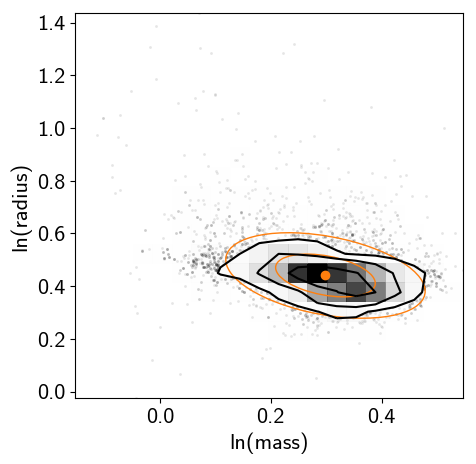

In [20]:
# Extract a Gaussian approximation to the mass and radius
log_mass = np.log(np.array(mod._derived_samples.mass))
log_radius = np.log(np.array(mod._derived_samples.radius))
samples = np.vstack((log_mass, log_radius))
log_mass_radius_mu = np.mean(samples, axis=1)
log_mass_radius_cov = np.cov(samples)

# Plot this approximation in 2D
fig, ax = plt.subplots(figsize=(5, 5))
corner.hist2d(log_mass, log_radius, ax=ax)

# Plot the 1 and 2 "sigma" levels of the Gaussian as ellipses
vals, vecs = np.linalg.eig(log_mass_radius_cov)
vals = np.sqrt(vals)
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
for n in [1, 2]:
    ellipse = matplotlib.patches.Ellipse(
        xy=log_mass_radius_mu, width=vals[0]*2*n, height=vals[1]*2*n, angle=theta)
    ellipse.set_facecolor("none")
    ellipse.set_edgecolor("C1")
    ax.add_artist(ellipse)

ax.plot(log_mass_radius_mu[0], log_mass_radius_mu[1], "o", color="C1")
ax.set_xlabel("ln(mass)")
ax.set_ylabel("ln(radius)");

## Light curve pre-processing

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI {{{TOINUMBER}}} was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

In [21]:
# Download the target pixel files
sr = lk.search_lightcurvefile('TIC %i' % tic)
lc_collection = sr.download_all(quality_bitmask="hardest")
if lc_collection is None or not len(lc_collection):
    raise ValueError("we can't find any light curves")

# Extract the exposure time associated with the light curve
hdr = lc_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Loop over light curves and stitch
lc = lc_collection[0].PDCSAP_FLUX.remove_nans().normalize().remove_outliers()
for lc0 in lc_collection[1:]:
    lc = lc.append(lc0.PDCSAP_FLUX.remove_nans().normalize().remove_outliers())
    
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y_raw = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# This helper function shows the transit times
def indicate_transits(ax=None):
    if ax is None:
        ax = plt.gca()
    for i in range(len(periods)):
        mn = np.floor((x.min() - t0s[i]) / periods[i])
        mx = np.ceil((x.max() - t0s[i]) / periods[i])
        label = "planet {0}".format(letters[i])
        for ind in range(int(mn), int(mx + 1)):
            ax.axvline(t0s[i] + ind * periods[i], color="C{0}".format(i),
                       linewidth=1, alpha=0.4, label=label)
            label = None

# Plot the data
lc.scatter()
indicate_transits()
plt.legend(fontsize=10)
plt.xlim(x.min(), x.max());

/Users/dforeman/anaconda3/lib/python3.6/site-packages/lightkurve/search.py:227: LightkurveWarning: Cannot download from an empty search result.
  LightkurveWarning)


ValueError: we can't find any light curves

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [ ]:
# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y_raw)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y_raw)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2))
    pm.Potential("loglike", gp.log_likelihood(y_raw))
    
    map_soln = xo.optimize(vars=[logs2])
    map_soln = xo.optimize(map_soln, vars=[logsigma])
    map_soln = xo.optimize(map_soln, vars=[logrho])
    map_soln = xo.optimize(map_soln)
    gp_pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y = y_raw - gp_pred

# Plot the light curves
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
ax1.plot(x, y_raw, ".k", label="data")
ax1.plot(x, gp_pred, "g", label="gp model")

ax2.plot(x, y, ".k", label="de-trended data")

indicate_transits(ax1)
indicate_transits(ax2)

ax1.set_title("stellar variability fit")
ax1.set_ylabel("flux [ppt]")
ax2.set_ylabel("de-trended flux [ppt]")
ax2.set_xlabel("time [days]")
ax2.set_xlim(x.min(), x.max())

ax1.legend(fontsize=10)
fig.subplots_adjust(hspace=0.05);

## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `log_rho_star`: the log of stellar density (this will be constrained, correctly, by the logg value in the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the orbital periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [12]:
def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        # The stellar properties from above
        log_mr_star = pm.MvNormal("log_mr_star", mu=log_mass_radius_mu,
                                  chol=np.linalg.cholesky(log_mass_radius_cov),
                                  shape=2)        
        m_star = pm.Deterministic("m_star", tt.exp(log_mr_star[0]))
        r_star = pm.Deterministic("r_star", tt.exp(log_mr_star[1]))        

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        log_period = pm.Normal("log_period", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(log_period))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The radius ratio
        ror_guess = np.clip(np.sqrt(1e-3*np.array(depths)), 0.001+1e-5, 1.0-1e-5)
        log_ror = pm.Uniform("log_ror", lower=np.log(0.001), upper=0.0,
                             testval=np.log(ror_guess), shape=n_planets)
        ror = pm.Deterministic("ror", tt.exp(log_ror))
        r_pl = pm.Deterministic("r_pl", ror * r_star)
        
        # The impact parameter
        b_hat = xo.distributions.UnitUniform("b_hat", shape=n_planets)
        b = pm.Deterministic("b", b_hat * (1 + ror))
        
        # Eccentricity
        ecc = xo.distributions.UnitUniform("ecc", shape=n_planets, testval=0.01+np.zeros(n_planets))
        omega = xo.distributions.Angle("omega", shape=n_planets)

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, m_star=m_star,
            ecc=ecc, omega=omega)
        pm.Deterministic("rho_star", model.orbit.rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        log_s2 = pm.Normal("log_s2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(log_s2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[log_s2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[log_ror, mean])
        map_soln = xo.optimize(start=map_soln, vars=[b_hat, mean])
        map_soln = xo.optimize(start=map_soln, vars=[log_mr_star])
        map_soln = xo.optimize(start=map_soln, vars=[log_period, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[log_ror, b_hat, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model


def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=7.0, maxiter=10, start=None):
    ntot = len(x)
    mask = np.ones_like(x, dtype=bool)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start, mask=mask)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y[mask] - mod
        rms = np.sqrt(np.mean(resid**2))
        mask[mask] = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        
        start["log_period"] = np.log(periods)
        start["t0"] = t0s
        ntot = mask.sum()
    
    model.mask = mask
    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***
optimizing logp for variables: ['mean', 'log_s2']
message: Desired error not necessarily achieved due to precision loss.
logp: -85398.17236357226 -> -85311.65186071182
optimizing logp for variables: ['mean', 'log_ror_interval__']
message: Optimization terminated successfully.
logp: -85311.65186071182 -> -85272.84704983646
optimizing logp for variables: ['mean', 'b_hat_logodds__']
message: Desired error not necessarily achieved due to precision loss.
logp: -85272.84704983646 -> -85272.8465488106
optimizing logp for variables: ['log_m_star', 'log_r_star']
message: Optimization terminated successfully.
logp: -85272.8465488106 -> -85264.58798123075
optimizing logp for variables: ['mean', 't0', 'log_period']
message: Desired error not necessarily achieved due to precision loss.
logp: -85264.58798123075 -> -85264.11258375138
optimizing logp for variables: ['mean', 'b_hat_logodds__', 'log_ror_interval__']
message: Optimization terminated successfully.
logp: -852

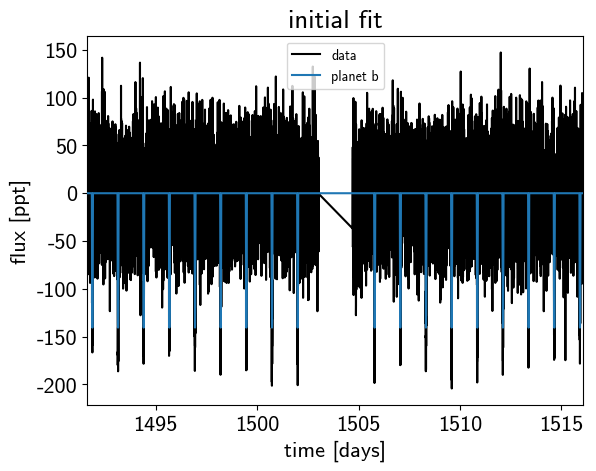

In [13]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [14]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=150, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=4000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=2000, chains=2, cores=2)

Sampling 2 chains: 100%|██████████| 4000/4000 [02:03<00:00, 32.29draws/s]
ERROR:pymc3:There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 34 divergences after tuning. Increase `target_accept` or reparameterize.


Save the results of the sampling to a file:

In [15]:
df_var = pm.trace_to_dataframe(trace, varnames=trace.varnames)
df_stat = pd.DataFrame(dict((k, trace[k]) for k in trace.stat_names))
df_var.to_hdf(os.path.join(output_dir, "planet.h5"), "vars")
df_stat.to_hdf(os.path.join(output_dir, "planet.h5"), "stats")

We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [16]:
names = []
for v in model.vars:
    if not v.name.endswith("__"):
        names.append(v.name)
names += [v.name for v in model.deterministics]
summary = pm.summary(trace, varnames=names)
summary.to_csv(os.path.join(output_dir, "summary.csv"))
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,1.456134,0.501511,8.729605e-03,0.447415,2.377861,2735.819190,0.999834
log_m_star,-0.969813,0.073344,2.043959e-03,-1.112101,-0.827791,1238.253885,0.999762
log_r_star,-1.002937,0.067168,2.187876e-03,-1.118172,-0.844387,902.570025,0.999750
t0__0,1491.877255,0.000640,1.103557e-05,1491.875988,1491.878487,3485.739853,0.999750
log_period__0,0.235245,0.000046,8.468507e-07,0.235158,0.235337,3224.708065,0.999906
log_s2,-7.256265,5.352876,1.363622e-01,-18.289572,0.638281,1585.120759,0.999966
m_star,0.380179,0.028097,7.943204e-04,0.328867,0.437014,1216.646101,0.999768
r_star,0.367633,0.024921,8.360941e-04,0.315997,0.416235,851.639701,0.999754
period__0,1.265219,0.000058,1.071450e-06,1.265109,1.265335,3224.724530,0.999906
u__0,0.485291,0.296081,7.481860e-03,0.001135,1.005038,1768.310681,0.999754


And then plot the posterior constraints on the folded transit models.

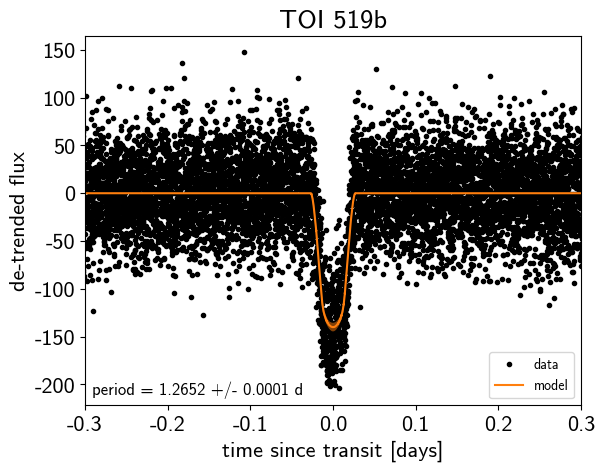

In [17]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

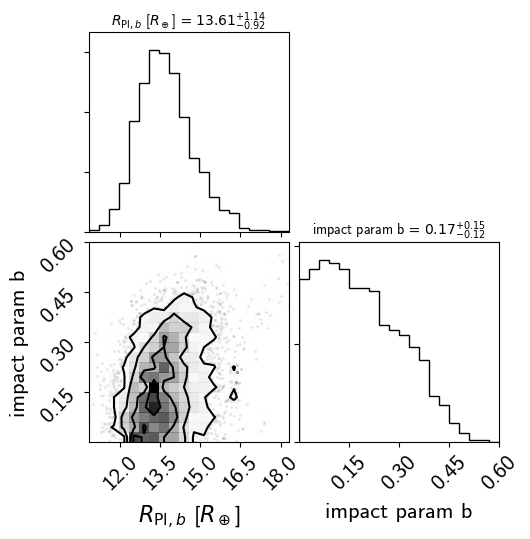

In [18]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

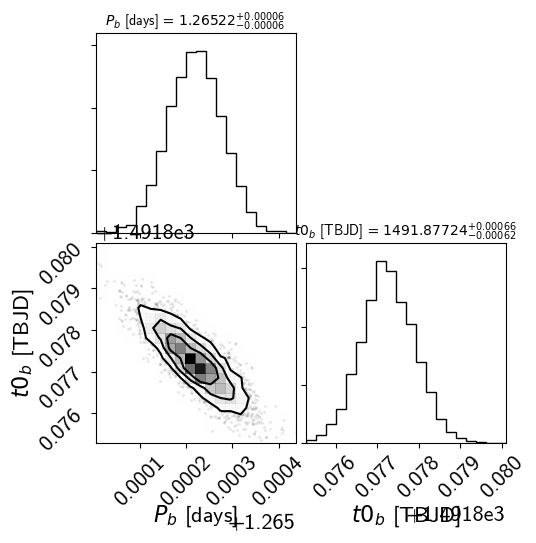

In [19]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

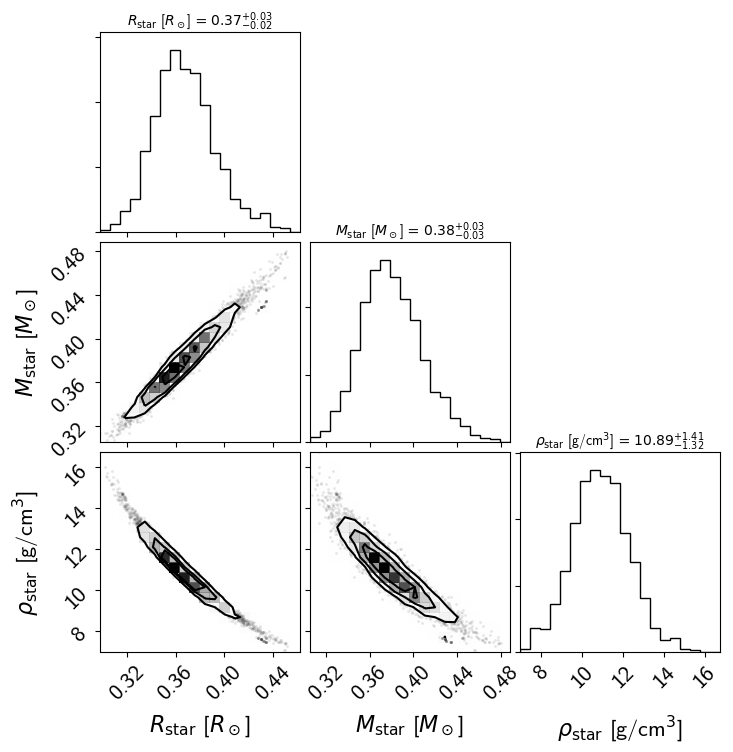

In [20]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$M_\mathrm{star}$ [$M_\odot$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["m_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [21]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3,
exoplanet:theano}.


and BibTeX entries:

In [22]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Eric Agol and
            Rodrigo Luger and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.2.0},
   month = aug,
    year = 2019,
     doi = {10.5281/zenodo.3359880},
     url = {https://doi.org/10.5281/zenodo.3359880}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficien

## Environment

This notebook was run with the following conda environment:

In [ ]:
!conda env export